#Финальный проект по курсу "Школа ДС"


Целью проекта является построение моделей для выявления мошеннических транзакций по кредитным картам.

Проект основан на открытых данных с Kaggle. Данные созданы синтетически с помощью симулятора PaySim, который использует для своей работы реальные данные.

Ссылка на датасет: [Kaggle](https://www.kaggle.com/ntnu-testimon/paysim1)

Для построения модели будут использованы следующие методы:

*   KNN
*   Логистическая регрессия
*   SVM
*   Градиентный бустинг (XGBoost)

# Загрузка библиотек и данных

##### Импортируем все необходимые библиотеки


In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, ADASYN

from warnings import filterwarnings

import joblib

# Если вычисления на платформе от гугл, то раскомментировать
from google.colab import drive

%matplotlib inline
filterwarnings('ignore')

##### Необходимые функции

Функция отделяет целевую переменную от данных

In [2]:
def data_split(df, target_value):
  y = df[target_value].values
  X = np.array(df.drop(target_value, axis = 1))
  return X, y

Функция масштабирует признаки

In [3]:
def data_scale(array):
  return scale(np.array(array, dtype='float'), with_std=True, with_mean=True)

Функция кодирует категориальные поля в датасете

In [4]:
def number_encode_features(init_df):
    result = init_df.copy() 
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

Следующие функции сохраняют и загружают модель

In [5]:
PATH_TO_MODELS = "/content/drive/MyDrive/dataset/models_data_test/"

def model_save(model, filename):
  return joblib.dump(model, "/content/drive/MyDrive/dataset/models_data_test/" + filename + '.ml')
  #return joblib.dump(model, "D:/Desktop/ds/hw/final project/models_data_test/" + filename + '.ml')

In [6]:
def model_load(filename):
  return joblib.load("/content/drive/MyDrive/dataset/models_data_test/" + filename + '.ml')
  #return joblib.load("D:/Desktop/ds/hw/final project/models_data_test/" + filename + '.ml')

In [7]:
def is_model_data_exist(filename):
  return os.path.isfile(PATH_TO_MODELS + filename + '.ml')

Функция производит поиск параметров для модели

In [8]:
def find_parameters(model_type, grid, x_train, y_train, cv=5):
  gs = GridSearchCV(estimator = model_type, param_grid = grid, cv = cv)
  gs.fit(x_train, y_train)

  return gs

##### Монтируем папку гугл grive

In [9]:
drive.mount('/content/drive')

##### Загружаем датасет

Для проекта будет использоваться только часть данных, т.к. использование полных данных приводит к очень длительному времени обучения моделей и подбора параметров моделей

In [10]:
%%time
df_orig = pd.read_csv(os.path.abspath("/content/drive/MyDrive/dataset/dataset.csv"), nrows = 1500000)
#df_orig = pd.read_csv(os.path.abspath("D:/Desktop/ds/hw/final project/dataset/PS_20174392719_1491204439457_log.csv"), nrows = 1500000)

Wall time: 2.74 s


Описание признаков:
type - тип транзакции (PAYMENT, TRANSFER, CASH_OUT, CASH_IN, DEBIT)

amount - сумма транзакции

nameOrig - идентификатор клиента

oldbalanceOrg - начальный баланс до транзакции

newbalanceOrig - новый баланс после транзакции

nameDest - клиент получатель

oldbalanceDest - баланс получателя до транзакции

newbalanceDest - баланс получателя после транзакции

isFraud - мошенническая транзакция или нет

isFlaggedFraud - бизнес-модель направлена ​​на контроль массовых переводов с одной учетной записи на другую и выявление незаконных попыток. Незаконная попытка в этом наборе данных - это попытка передать более 200 000 за одну транзакцию.

# Анализ данных

Проверим, корректно ли загрузились данные

In [11]:
df_orig.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


Посмотрим количество строк и столбцов

In [12]:
df_orig.shape

(1500000, 11)

Посмотрим на стандартную статистику

In [13]:
df_orig.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1500000.0
mean,5.915070e+01,1.608296e+05,8.674607e+05,8.882571e+05,9.893854e+05,1.114852e+06,1.072000e-03,0.0
std,5.092537e+01,2.676604e+05,2.951755e+06,2.988126e+06,2.301935e+06,2.406376e+06,3.272387e-02,0.0
min,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.700000e+01,1.298844e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,3.800000e+01,7.802889e+04,1.528600e+04,0.000000e+00,1.336265e+05,2.244404e+05,0.000000e+00,0.0
75%,1.300000e+02,2.162310e+05,1.257779e+05,1.670238e+05,9.364515e+05,1.152679e+06,0.000000e+00,0.0
max,1.430000e+02,1.000000e+07,3.893942e+07,3.894623e+07,4.220740e+07,4.220740e+07,1.000000e+00,0.0


Никакой интересной информации это нам не дало. Идем дальше

Проверим, есть ли пропуски в данных

In [14]:
df_orig.isnull().any()

step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
isFlaggedFraud    False
dtype: bool

Отлично, пропусков нет

Проверим, какие типы данных есть в датасете

In [15]:
df_orig.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Посмотрим, какие типы транзакций присутствуют в датасете


In [16]:
df_orig['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

Посмотрим на распределение признаков

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018090CD5610>,
      dtype=object)

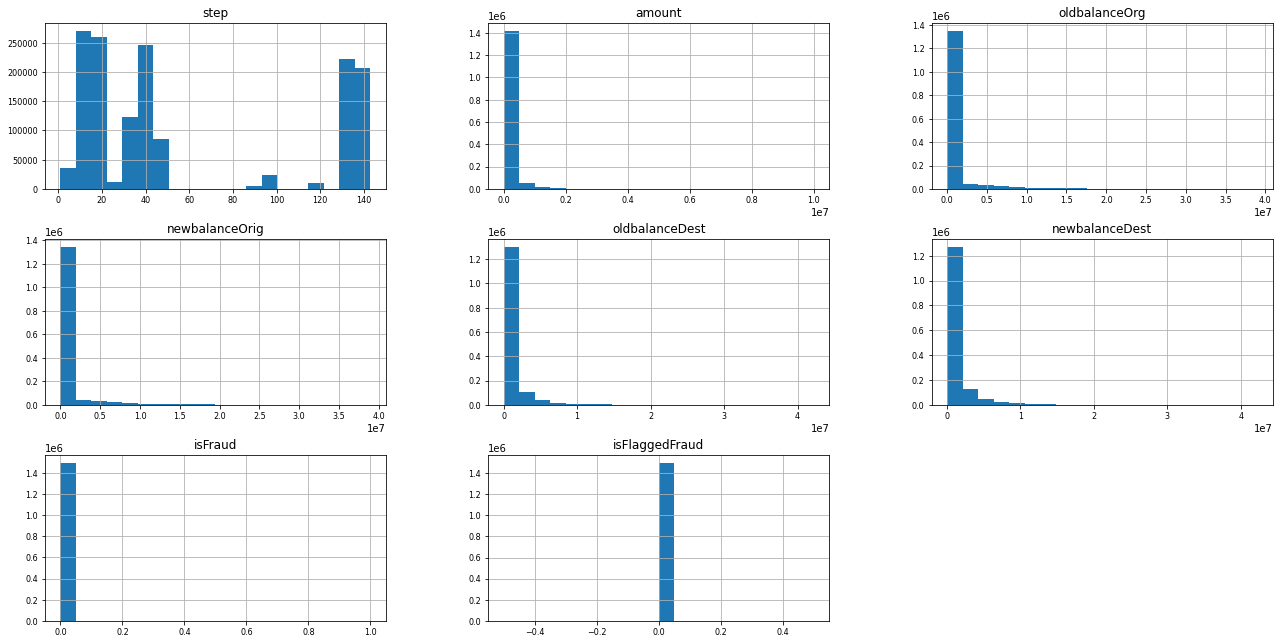

In [17]:
df_orig.hist(figsize=(22,11), xlabelsize = 8, ylabelsize = 8, bins = 20)

Некоторые не числовые признаки не вошли в график. Посмотрим их отдельно

Распределение по типам транзакций

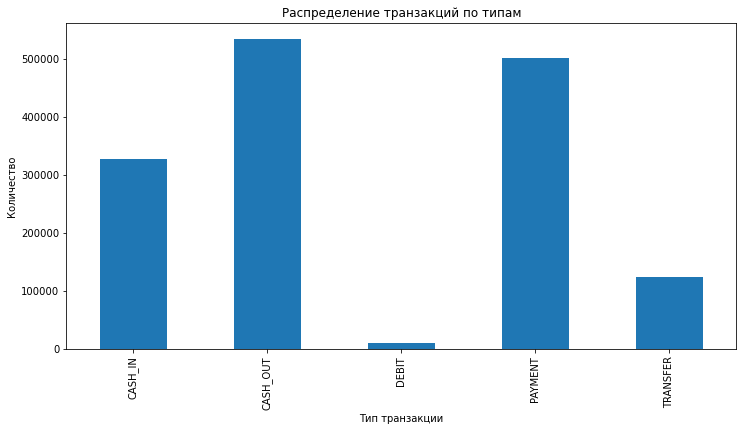

In [18]:
df_orig.groupby('type')['type'].count().plot.bar(
    figsize = (12,6),
    title = 'Распределение транзакций по типам',
    xlabel = 'Тип транзакции',
    ylabel = 'Количество')

Посмотрим на количество мошеннических тразнакций

In [19]:
df_orig.groupby('isFraud')['isFraud'].count()

isFraud
0    1498392
1       1608
Name: isFraud, dtype: int64

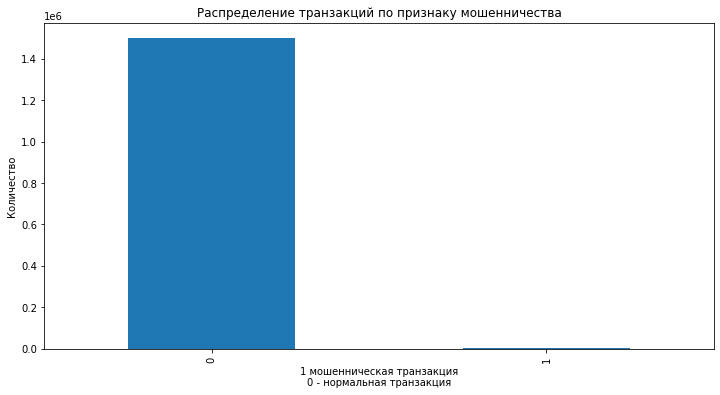

In [20]:
df_orig.groupby('isFraud')['isFraud'].count().plot.bar(figsize = (12,6),
                                                       title = 'Распределение транзакций по признаку мошенничества',
                                                       xlabel = '1 мошенническая транзакция\n0 - нормальная транзакция',
                                                       ylabel = 'Количество')

Мы видим, что количество мошеннических транзакций очень мало по сравнению с нормальными транзакциями. Датасет очень несбалансированный

Распределение мошеннических транзакций по типам

In [21]:
df_fraud = df_orig[df_orig['isFraud'] == 1]

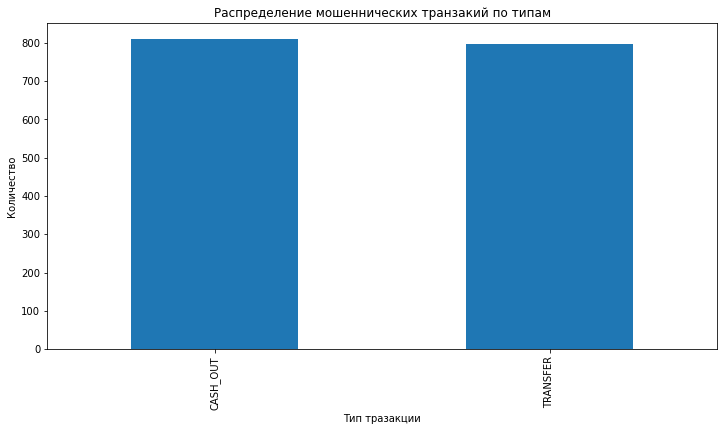

In [22]:
df_fraud.groupby('type')['type'].count().plot.bar(figsize = (12,6),
                                                  title = 'Распределение мошеннических транзакий по типам',
                                                  xlabel = 'Тип тразакции',
                                                  ylabel = 'Количество')

Мы видим, что мошенничество происходило только по двум типам операций: CASH OUT и TRANSFER

Посмотриv как между собой коррелируют признаки

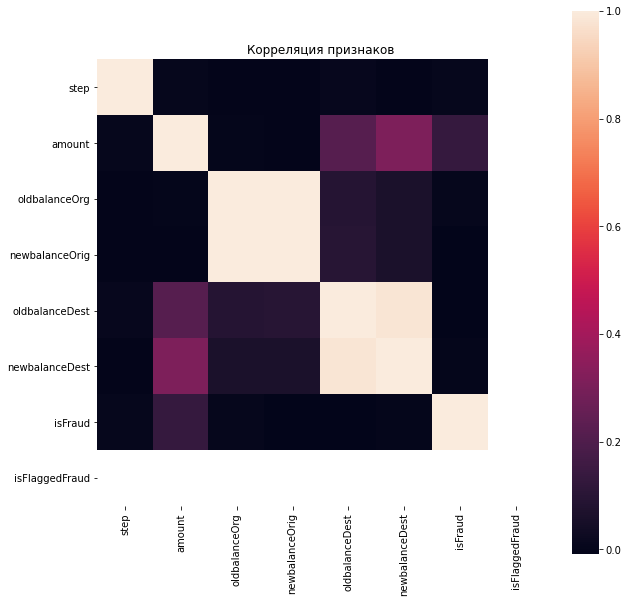

In [23]:
plt.subplots(figsize=(10,10))
sns.heatmap(df_orig.corr(), square=True)
plt.title('Корреляция признаков')
plt.show()

Мы видим корреляцию newBalanceOrig с oldBalanceOrg, и newbalanceDest с oldBalanceDest. Сначала попробуем обучить модель с этими признаками. Потом удалим их и сравним результаты. 

# Подготовка данных

Для начала удалим ненужные столбцы. У нас это имена клиентов и Step

In [24]:
df_drop = df_orig.drop(['nameOrig', 'nameDest', 'step'], axis = 1)

In [25]:
df_drop

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,PAYMENT,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,TRANSFER,181.00,181.00,0.00,0.00,0.00,1,0
3,CASH_OUT,181.00,181.00,0.00,21182.00,0.00,1,0
4,PAYMENT,11668.14,41554.00,29885.86,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...
1499995,PAYMENT,19785.10,3158.73,0.00,0.00,0.00,0,0
1499996,CASH_OUT,365830.64,595.00,0.00,0.00,365830.64,0,0
1499997,PAYMENT,11252.75,0.00,0.00,0.00,0.00,0,0
1499998,PAYMENT,8493.33,0.00,0.00,0.00,0.00,0,0


Далее закодируем строковые типы. Из таких у нас остался только столбец type

In [26]:
df_encoded, encoders = number_encode_features(df_drop)
df_encoded.head() 

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


In [27]:
encoders

{'type': LabelEncoder()}

Выделим целевую переменную в переменную y, остальные данные в переменную Х

In [28]:
X, y = data_split(df_encoded, 'isFraud')

In [29]:
X

array([[3.0000000e+00, 9.8396400e+03, 1.7013600e+05, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0000000e+00, 1.8642800e+03, 2.1249000e+04, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [4.0000000e+00, 1.8100000e+02, 1.8100000e+02, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [3.0000000e+00, 1.1252750e+04, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0000000e+00, 8.4933300e+03, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.7233141e+05, 1.0410000e+03, ..., 2.4766550e+04,
        0.0000000e+00, 0.0000000e+00]])

In [30]:
y

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

Нормализуем признаки

In [31]:
X = data_scale(X)

In [32]:
X

array([[ 0.96187165, -0.5641106 , -0.23624083, ..., -0.42980605,
        -0.46329104,  0.        ],
       [ 0.96187165, -0.59390717, -0.28668102, ..., -0.42980605,
        -0.46329104,  0.        ],
       [ 1.70485038, -0.60019604, -0.29381847, ..., -0.42980605,
        -0.46329104,  0.        ],
       ...,
       [ 0.96187165, -0.55883111, -0.29387979, ..., -0.42980605,
        -0.46329104,  0.        ],
       [ 0.96187165, -0.56914052, -0.29387979, ..., -0.42980605,
        -0.46329104,  0.        ],
       [-1.26706453,  0.04297152, -0.29352712, ..., -0.41904703,
        -0.46329104,  0.        ]])

Разделим датасет на обучающую и тестовую выборку

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=555)

# Создание и обучение моделей

### KNN

#### Необходимые функции


Функция для отрисовки графика

In [34]:
def grid_plot(x, y, x_label, title, y_label='cross_val, accuracy'):
    # определили размер графика
    plt.figure(figsize=(12, 6))
    # добавили сетку на фон
    plt.grid(True)
    # построили по х - число соседей, по y - точность
    plt.plot(x, y, 'go-')
    # добавили подписи осей и название графика
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

Функция печатает подобранные параметры

In [35]:
def print_best_params(gs):
  print(gs.best_params_, gs.best_score_)

Функция для обучения модели и выдачи результатов

In [36]:
def fit_predict_knn(gs, x_train, y_train, x_test, y_test, print_result=True, save = True, filename = None):
  knn = None
  if is_model_data_exist(filename):
    knn = model_load(filename)
    save = False
    print(filename + ' existing\n')
  else:
    knn = KNeighborsClassifier(**gs.best_params_)
    knn.fit(x_train, y_train)

  preds = knn.predict(x_test)
  if print_result: print(metrics.classification_report(y_test, preds))
  if save: model_save(knn, filename)
  return preds

#### Создание и обучение модели

In [37]:
%%time
knn_grid = {'n_neighbors': np.array(np.arange(1,14), dtype='int')}
knn_gs = find_parameters(KNeighborsClassifier(), knn_grid, X_train[:50000], y_train[:50000])

Wall time: 1min 8s


На графике ниже мы видим точность модели в зависимости от количества соседей. Максимальная точность достигается при 3 соседях рядом

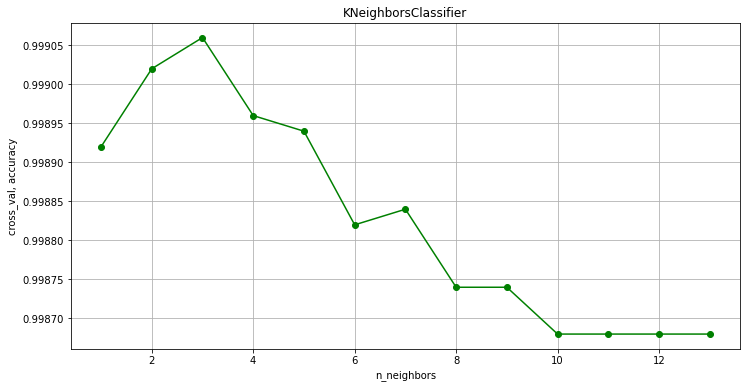

In [38]:
grid_plot(knn_grid['n_neighbors'], knn_gs.cv_results_['mean_test_score'], 'n_neighbors', 'KNeighborsClassifier')

In [39]:
print_best_params(knn_gs)

{'n_neighbors': 3} 0.9990600000000001


In [40]:
%%time
fit_predict_knn(knn_gs, X_train, y_train, X_test, y_test, filename = 'knn_no_aug')

knn_no_aug existing

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299696
           1       0.85      0.66      0.74       304

    accuracy                           1.00    300000
   macro avg       0.92      0.83      0.87    300000
weighted avg       1.00      1.00      1.00    300000

Wall time: 33.7 s


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Достаточно неплохой результат. precision и recall для второго класса на хорошем уровне, если учесть что этот класс в выборке очень небольшой

### Логистическая регрессия


#### Необходимые функции

In [41]:
def fit_predict_log(gs, x_train, y_train, x_test, y_test, print_result=True, class_weight = None, save = True, filename = None):
  log = None
  if is_model_data_exist(filename):
    log = model_load(filename)
    save = False
  else:
    log = LogisticRegression(**gs.best_params_)
    log.fit(x_train, y_train)

  preds = log.predict(x_test)
  if print_result: print(metrics.classification_report(y_test, preds))
  if save: model_save(log, filename)

  return preds

#### Создание и обучение модели

In [42]:
%%time
log_grid = {
    "C":list(np.linspace(0.1,1,20, dtype='float')), 
    "penalty":["l1","l2"], 
    "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 
}
log_gs = find_parameters(LogisticRegression(), log_grid, X_train[:50000], y_train[:50000])

Wall time: 4min 48s


In [43]:
print_best_params(log_gs)

{'C': 0.43157894736842106, 'penalty': 'l1', 'solver': 'liblinear'} 0.999


In [44]:
%%time
fit_predict_log(log_gs, X_train, y_train, X_test, y_test, filename = 'log_no_aug')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299696
           1       0.89      0.35      0.50       304

    accuracy                           1.00    300000
   macro avg       0.95      0.68      0.75    300000
weighted avg       1.00      1.00      1.00    300000

Wall time: 418 ms


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Результат немнго хуже чем у KNN

### SVM

#### Необходимые функции

In [45]:
def fit_predict_svc(gs, x_train, y_train, x_test, y_test, print_result=True, save = True, filename = None):
  svc = None
  if is_model_data_exist(filename):
    svc = model_load(filename)
    save = False
  else:
    svc = SVC(**gs.best_params_)
    svc.fit(x_train, y_train)
    
  preds = svc.predict(x_test)
  if print_result: print(metrics.classification_report(y_test, preds))
  if save: model_save(svc, filename)
  
  return preds

#### Создание и обучение модели

In [46]:
%%time
grid_svm = {
    "C":list(np.linspace(0.1,1,20, dtype='float')),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}
svm_gs = find_parameters(SVC(), grid_svm, X_train[:50000], y_train[:50000])

Wall time: 2min 36s


In [47]:
print_best_params(svm_gs)

{'C': 0.1473684210526316, 'kernel': 'poly'} 0.9991


In [48]:
%%time
fit_predict_svc(svm_gs, X_train, y_train, X_test, y_test, filename = 'svm_no_aug')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299696
           1       0.99      0.28      0.44       304

    accuracy                           1.00    300000
   macro avg       0.99      0.64      0.72    300000
weighted avg       1.00      1.00      1.00    300000

Wall time: 7.18 s


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Мы видим, что модель практически не ошибалась в предсказании. Однако, не все мошеннические транзакции смогла распознать

### XGBoost

In [49]:
def xgboost_fit_predict(x_train, y_train, x_test, y_test, print_result=True, save = True, filename = None):
  model = XGBClassifier()
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  if print_result: print(metrics.classification_report(y_test, pred))
  if save: model_save(model, filename)

  return pred

In [50]:
%%time
xgboost_fit_predict(X_train, y_train, X_test, y_test, filename = 'xgb_no_aug')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    299696
           1       0.95      0.71      0.81       304

    accuracy                           1.00    300000
   macro avg       0.97      0.86      0.91    300000
weighted avg       1.00      1.00      1.00    300000

Wall time: 48.1 s


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Самый лучший результат из всех

# Промежуточный вывод

Мы видим, что наши модели не могут хорошо распознавать второй класс (мошеннические транзакции). Попробуем исправить это с помощью аугментации данных

# Аугментация данных


In [51]:
def oversample_data(X, y):
    return ADASYN(sampling_strategy='minority').fit_resample(np.array(X), np.array(y))

In [52]:
X_train_aug, y_train_aug = oversample_data(X_train, y_train)

In [53]:
y_train_aug.shape

(2397425,)

# Обучение моделей на аугментированных данных

Здесь мы не будем снова подбирать параметры для моделей на аугментированных данных, т.к. это занимает очень много времени. Сразу будем обучать на уже подобранных параметрах

### KNN


In [57]:
%%time
fit_predict_knn(knn_gs, X_train_aug, y_train_aug, X_test, y_test, filename = 'knn_aug')

knn_aug existing

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    299696
           1       0.11      0.81      0.19       304

    accuracy                           0.99    300000
   macro avg       0.55      0.90      0.59    300000
weighted avg       1.00      0.99      1.00    300000

Wall time: 32.9 s


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

Результат противоречивый

### Логистическая регрессия

In [60]:
%%time
fit_predict_log(log_gs, X_train_aug, y_train_aug, X_test, y_test, filename = 'log_aug')

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    299696
           1       0.01      0.89      0.03       304

    accuracy                           0.94    300000
   macro avg       0.51      0.91      0.50    300000
weighted avg       1.00      0.94      0.97    300000

Wall time: 431 ms


array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

### SVM

In [ ]:
%%time
fit_predict_svc(svm_gs, X_train_aug, y_train_aug, X_test, y_test, filename = 'svm_aug')

К сожалению, результатов обучения по данной модели я не дождался. Это либо баг либо очень долгая работа алгоритма. Погуглив, нашел [людей с такой же проблемой](https://github.com/scikit-learn/scikit-learn/issues/4648)

### XGBoost

In [ ]:
%%time
xgboost_fit_predict(X_train_aug, y_train_aug, X_test, y_test, filename = 'xgb_aug')

In [ ]:
%%time
xgboost_fit_predict(X_train_aug, y_train_aug, X_test, y_test, filename = 'xgb_aug')

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    299696
           1       0.15      0.98      0.27       304

    accuracy                           0.99    300000
   macro avg       0.58      0.99      0.63    300000
weighted avg       1.00      0.99      1.00    300000

Wall time: 2min 20s


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

# Вывод

В результате обучения моделей на аугментированных данных мы видим, что precision уменьшился, а recall увеличился. 
Получается, что наши модели стали находить больше мошеннических транзакций среди остальных, но в то же время, стали больше ошибаться и относить к мошенническим транзакциям не мошеннические.

Возможно, стоило детальнее анализировать данные перед формированием признаков и выявить еще какие-либо зависимости для увеличения precision. 

Возможно, стоило удалить из выборки все транзакции кроме CASH_OUT И TRANSFER, т.к. мошеннические транзакции совершались только по ним